In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import zipfile 
from urllib.request import urlopen
from io import BytesIO

import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts import time_feature
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
# Load data

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv'
df = pd.read_csv(url, index_col=0)
df.shape

(19735, 28)

In [3]:
# check columns:

df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'], dtype='object')

In [4]:
# define target and features:

target_cols = [col for col in df.columns if 'T' in col and len(col) <=2]
features_room = [col for col in df.columns if 'RH' in col and len(col) <=4]
features_outside = list(filter(lambda x:x not in target_cols+features_room, 
                               df.columns))

In [24]:
# normalize input data:

input_cols = features_room+features_outside

norm_df = df[input_cols].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
final_df = pd.concat([df[target_cols], norm_df], ignore_index=False, sort=False, axis=1)

In [26]:
# return values:

target = final_df[target_cols].T.values
f_room = final_df[features_room].T.values
f_outside = final_df[features_outside].T.values

In [27]:
# Loop through features creating a dict
# and using the stacked values to create
# dynamic features in required shape:

dct={}

for i,v in enumerate(range(len(f_room))):
    dct[i] = np.vstack((f_room[i],f_outside))
    
feat_dynamic_real = np.stack((dct.values()))    
feat_dynamic_real.shape

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(9, 11, 19735)

In [28]:
# define the parameters of the dataset:

custom_ds_metadata = {
    'num_series': len(target), # because we have only one target ts
    'num_steps': df.shape[0], # defines the length of the ts
    'prediction_length': 250, # number of steps we want to predict
    'freq': '10min', # data is given in 10 min steps
    'start': [
        pd.Timestamp(df.index[0], freq='10m')
        for _ in range(df.shape[0])
    ]
}

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:,:, :-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [30]:
# check length of train and test
# to see if we have 9 ts:

print(len(train_ds),
      len(test_ds))

9 9


In [31]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source']) dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


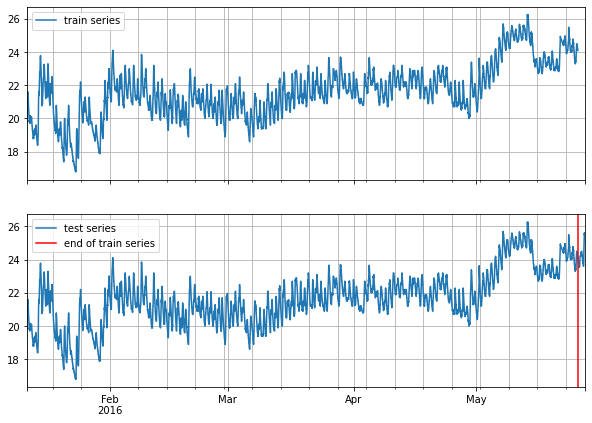

In [32]:
# plot train and testing data:

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=59,
                            num_layers=2,
                            num_cells=40,
                            use_feat_dynamic_real=True,
                            context_length=5*custom_ds_metadata['prediction_length'],
                            trainer=Trainer(epochs=2,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=32,
                                            batch_size=128,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [35]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|████████████████████████| 9/9 [00:00<00:00, 130.58it/s]/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



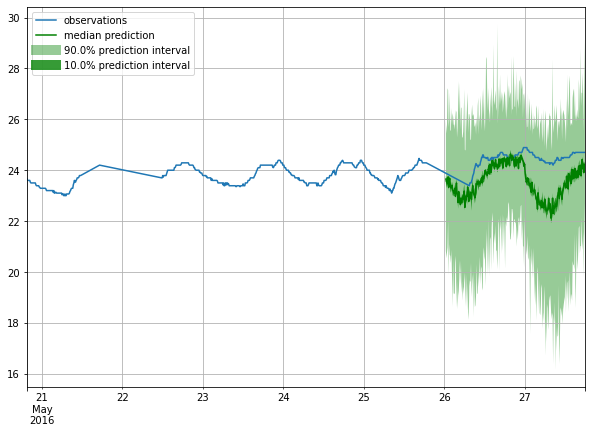

In [44]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 4*custom_ds_metadata['prediction_length']
    prediction_intervals = (10.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecast_entry = forecasts[3]
ts_entry = tss[3]
plot_prob_forecasts(ts_entry, forecast_entry) 

In [38]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9.167691175672743,
    "abs_error": 3531.7669372558594,
    "abs_target_sum": 52733.0625,
    "abs_target_mean": 23.436916666666665,
    "seasonal_error": 0.8516405491500496,
    "MASE": 1.6983393105033318,
    "MAPE": 0.06764124382866754,
    "sMAPE": 0.07742135535346137,
    "MSIS": 21.052129032301263,
    "QuantileLoss[0.1]": 1765.5418029785158,
    "Coverage[0.1]": 0.0017777777777777779,
    "QuantileLoss[0.2]": 2601.1306091308597,
    "Coverage[0.2]": 0.016888888888888887,
    "QuantileLoss[0.3]": 3111.321654319763,
    "Coverage[0.3]": 0.044444444444444446,
    "QuantileLoss[0.4]": 3396.490941238404,
    "Coverage[0.4]": 0.10933333333333334,
    "QuantileLoss[0.5]": 3531.7669553756714,
    "Coverage[0.5]": 0.19822222222222222,
    "QuantileLoss[0.6]": 3572.8230712890618,
    "Coverage[0.6]": 0.30666666666666664,
    "QuantileLoss[0.7]": 3447.994878578186,
    "Coverage[0.7]": 0.49377777777777776,
    "QuantileLoss[0.8]": 3255.2588806152344,
    "Coverage[0.8]": 0.689